In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import keras

Using TensorFlow backend.


In [27]:
imputed_train = pd.read_csv("csvfiles/train_processed_pca50.csv").iloc[:,1:]

In [28]:
imputed_vali = pd.read_csv("csvfiles/vali_processed_pca50.csv").iloc[:,1:]

In [29]:
numeric_cols = ['click_timestamp', 'integer_feature_1', 'integer_feature_2',
       'integer_feature_3', 'integer_feature_4', 'integer_feature_5',
       'integer_feature_6', 'integer_feature_7', 'integer_feature_8']

In [30]:
scaler = StandardScaler() 
numeric_train = scaler.fit_transform( imputed_train[numeric_cols] ) 
numeric_vali = scaler.transform( imputed_vali[numeric_cols] ) 

In [31]:
imputed_train[numeric_cols] = numeric_train
imputed_vali[numeric_cols] = numeric_vali

In [32]:
concat_df = pd.concat([imputed_train, imputed_vali],axis=0)

In [33]:
window=2

In [34]:
# x_train
def past_features_create(df, window=100):
    for i in range(1,9):
        df['avg_int'+str(i)] = df['integer_feature_'+str(i)].rolling(window=window).mean() 
        df['var_int'+str(i)] = df['integer_feature_'+str(i)].rolling(window=window).std() 
        df['avg_int'+str(i)+'_5'] = df['integer_feature_'+str(i)].rolling(window=window*5).mean() 
        df['var_int'+str(i)+'_5'] = df['integer_feature_'+str(i)].rolling(window=window*5).std() 
        df['avg_int'+str(i)+'_10'] = df['integer_feature_'+str(i)].rolling(window=window*10).mean() 
        df['var_int'+str(i)+'_10'] = df['integer_feature_'+str(i)].rolling(window=window*10).std() 
    return df

In [35]:
concat_df_timefeatures = past_features_create(concat_df,  window=window).iloc[10*window-1:,:]

In [36]:
train = concat_df_timefeatures.iloc[:-len(imputed_vali),:]
vali = concat_df_timefeatures.iloc[-len(imputed_vali):,:]

In [37]:
y_train = train.pop('label')
x_train = train

In [38]:
y_vali = vali.pop('label')
x_vali = vali

In [39]:
print(x_train.shape, y_train.shape)

(499981, 462) (499981,)


In [42]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_vali = np.array(x_vali)
y_vali = np.array(y_vali)

In [50]:
len(y_vali)

493802

In [49]:
np.sum(y_vali==0) + np.sum(y_vali==1)

493802

In [52]:
nnmodel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),  
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),  
  tf.keras.layers.Dropout(0.5),  
  tf.keras.layers.Dense(2, activation='softmax')
])

# adam_opt = tf.keras.optimizers.Adam(
#     learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#     name='Adam', **kwargs
# )

nnmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# fit network
history = nnmodel.fit(x_train, y_train, epochs=30, batch_size=1000,
                  validation_data=(x_vali, y_vali),
                  verbose=1, 
                  shuffle=True)

Train on 499981 samples, validate on 493802 samples
Epoch 1/30
499981/499981 [==============================] - 7s 14us/sample - loss: 0.4713 - accuracy: 0.8025 - val_loss: 0.4413 - val_accuracy: 0.8091
Epoch 2/30
499981/499981 [==============================] - 5s 10us/sample - loss: 0.4450 - accuracy: 0.8137 - val_loss: 0.4326 - val_accuracy: 0.8140
Epoch 3/30
499981/499981 [==============================] - 6s 12us/sample - loss: 0.4380 - accuracy: 0.8164 - val_loss: 0.4276 - val_accuracy: 0.8171
Epoch 4/30
499981/499981 [==============================] - 6s 11us/sample - loss: 0.4337 - accuracy: 0.8186 - val_loss: 0.4267 - val_accuracy: 0.8178
Epoch 5/30
499981/499981 [==============================] - 5s 11us/sample - loss: 0.4309 - accuracy: 0.8198 - val_loss: 0.4244 - val_accuracy: 0.8203
Epoch 6/30
499981/499981 [==============================] - 7s 14us/sample - loss: 0.4296 - accuracy: 0.8208 - val_loss: 0.4237 - val_accuracy: 0.8215
Epoch 7/30
499981/499981 [================

In [56]:
y_pred = nnmodel.predict(x_vali)

In [57]:
acc_nn = accuracy_score(y_vali, np.argmax(y_pred, axis=1))
print(acc_nn)

0.8239982827125042


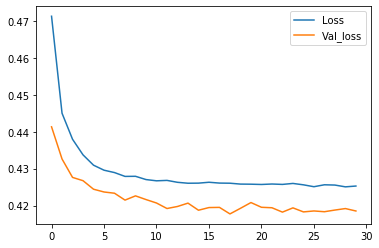

In [54]:
plt.plot(history.history['loss'][0:], label='Loss')
plt.plot(history.history['val_loss'][0:], label='Val_loss')
plt.legend()
plt.show()

Index(['click_timestamp', 'integer_feature_1', 'integer_feature_2',
       'integer_feature_3', 'integer_feature_4', 'integer_feature_5',
       'integer_feature_6', 'integer_feature_7', 'integer_feature_8',
       'categorical_feature_1_1',
       ...
       'avg_int7_5', 'var_int7_5', 'avg_int7_10', 'var_int7_10', 'avg_int8',
       'var_int8', 'avg_int8_5', 'var_int8_5', 'avg_int8_10', 'var_int8_10'],
      dtype='object', length=462)

In [71]:
X_train = x_train
colnames = train.columns

In [72]:
def data_gen():
    while True:
        x = np.random.rand(1000, 1, X_train.shape[1])  # batch x time x features
        yield x, x[:, :, 0] * x[:, :, 1] < 0.25

def var_importance(model, X_train=X_train):
    result = []
    g = data_gen()
    x = np.concatenate([next(g)[0] for _ in range(50)]) # Get a sample of data
    orig_out = model.predict(x)
    for i in range(len(colnames)):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        result.append(effect)
        print(f' {colnames[i]}, perturbation effect: {effect:.4f}')
    return result

In [ ]:
pertubation_test = var_importance(nnmodel)

 click_timestamp, perturbation effect: 0.0013
 integer_feature_1, perturbation effect: 0.0237
 integer_feature_2, perturbation effect: 0.0183
 integer_feature_3, perturbation effect: 0.0111
 integer_feature_4, perturbation effect: 0.0184
 integer_feature_5, perturbation effect: 0.0095
 integer_feature_6, perturbation effect: 0.0135
 integer_feature_7, perturbation effect: 0.0129
 integer_feature_8, perturbation effect: 0.0066
 categorical_feature_1_1, perturbation effect: 0.0008
 categorical_feature_1_2, perturbation effect: 0.0006
 categorical_feature_1_3, perturbation effect: 0.0003
 categorical_feature_1_4, perturbation effect: 0.0014
 categorical_feature_1_5, perturbation effect: 0.0005
 categorical_feature_1_6, perturbation effect: 0.0005
 categorical_feature_1_7, perturbation effect: 0.0002
 categorical_feature_1_8, perturbation effect: 0.0031
 categorical_feature_1_9, perturbation effect: 0.0017
 categorical_feature_1_10, perturbation effect: 0.0005
 categorical_feature_1_11, pe

 categorical_feature_3_43, perturbation effect: 0.0006
 categorical_feature_3_44, perturbation effect: 0.0000
 categorical_feature_3_45, perturbation effect: 0.0005
 categorical_feature_3_46, perturbation effect: 0.0006
 categorical_feature_3_47, perturbation effect: 0.0024
 categorical_feature_3_48, perturbation effect: 0.0005
 categorical_feature_3_49, perturbation effect: 0.0006
 categorical_feature_3_50, perturbation effect: 0.0010
 categorical_feature_4_1, perturbation effect: 0.0003
 categorical_feature_4_2, perturbation effect: 0.0004
 categorical_feature_4_3, perturbation effect: 0.0004
 categorical_feature_4_4, perturbation effect: 0.0010
 categorical_feature_4_5, perturbation effect: 0.0026
 categorical_feature_4_6, perturbation effect: 0.0004
 categorical_feature_4_7, perturbation effect: 0.0004
 categorical_feature_4_8, perturbation effect: 0.0005
 categorical_feature_4_9, perturbation effect: 0.0001
 categorical_feature_4_10, perturbation effect: 0.0008
 categorical_featur

 categorical_feature_6_43, perturbation effect: 0.0005
 categorical_feature_6_44, perturbation effect: 0.0005
 categorical_feature_6_45, perturbation effect: 0.0003
 categorical_feature_6_46, perturbation effect: 0.0015
 categorical_feature_6_47, perturbation effect: 0.0016
 categorical_feature_6_48, perturbation effect: 0.0013
 categorical_feature_6_49, perturbation effect: 0.0006
 categorical_feature_6_50, perturbation effect: 0.0013
 categorical_feature_7_1, perturbation effect: 0.0004
 categorical_feature_7_2, perturbation effect: 0.0004
 categorical_feature_7_3, perturbation effect: 0.0003
 categorical_feature_7_4, perturbation effect: 0.0007
 categorical_feature_7_5, perturbation effect: 0.0008
 categorical_feature_7_6, perturbation effect: 0.0005
 categorical_feature_7_7, perturbation effect: 0.0002
 categorical_feature_7_8, perturbation effect: 0.0002
 categorical_feature_7_9, perturbation effect: 0.0003
 categorical_feature_7_10, perturbation effect: 0.0003
 categorical_featur